In [2]:
Packages <- c("dplyr","broom","cubature", "geosphere", "data.table",  "ggplot2", "bbmle", "dplyr","tidyr", "stringr", "tidyverse", "lubridate", "RColorBrewer")

invisible(suppressPackageStartupMessages(lapply(Packages, library, character.only = TRUE)))

setwd('/local/home/katrinac/oceanography')
"%!in%" <- function(x,table) match(x,table, nomatch = 0) == 0
source("~/parentage/kernel_fitting/1340_loci/functions/ll_kt_both_bbmle.R")
source("~/parentage/kernel_fitting/1340_loci/functions/GenGausKernInt_sum0.5.R") #integrate_kernel_sum1
source("~/parentage/kernel_fitting/1340_loci/functions/GenGausKernInt_sum1.R") #integrate_kernel_sum0.5


In [ ]:
#calculate summary stats like mdd, median, kerutosis, and dist 90 retained
#plot summary stats with overlays of empirical fits
#test for rank ordered correlations


In [3]:
#read in the kernel ensembles
SimKernels2012 <- read.csv(file="~/oceanography/script_output/KernelFits/100SimulatedKernels2012.csv", header=T) %>%
    mutate(year=as.character(year)) %>%
    select(-mdd)
SimKernels2013 <- read.csv(file="~/oceanography/script_output/KernelFits/100SimulatedKernels2013.csv", header=T) %>%
    mutate(year=as.character(year))%>%
    select(-mdd)
SimKernels2014 <- read.csv(file="~/oceanography/script_output/KernelFits/100SimulatedKernels2014.csv", header=T) %>%
    mutate(year=as.character(year))%>%
    select(-mdd)
SimKernels2014SurvGrow <- read.csv(file="~/oceanography/script_output/KernelFits/100SimulatedKernels2014SurvGrowth.csv", header=T) %>%
    mutate(year=as.character(year))%>%
    select(-mdd)
SimKernelsAll <- read.csv(file="~/oceanography/script_output/KernelFits/1000SimulatedKernelsAllStoppedEarly.csv", header=T) %>%
    mutate(year="all")
CombinedSims <- bind_rows(SimKernels2012, SimKernels2013, SimKernels2014,  SimKernelsAll) 




In [26]:
SimKernels2014 <- read.csv(file="~/oceanography/script_output/KernelFits/100SimulatedKernels2014.csv", header=T) %>%
    mutate(year=as.character(year)) %>%
    mutate(AdjSurv="no")
SimKernels2014SurvGrow <- read.csv(file="~/oceanography/script_output/KernelFits/100SimulatedKernels2014SurvGrowth.csv", header=T) %>%
    mutate(year=as.character(year)) %>%
    mutate(AdjSurv="yes")

Test2014 <- bind_rows(SimKernels2014, SimKernels2014SurvGrow) %>%
    select(-iteration, -year) %>%
    group_by(AdjSurv) %>%
    summarise_each(funs(mean))

Test2014 %>%
    group_by(AdjSurv) %>%
    filter(k==10 |k==-10 | theta==0.15 |theta== 8) %>% #how often are the fits at the boundary? as in, bad
    summarise(NObsBad=n())

`summarise()` ungrouping output (override with `.groups` argument)


AdjSurv,NObsBad


In [65]:
#get a distribution of MDD from the combinations of theta and k 

col= "mdd"
MDDSimCombined <- as.data.frame(matrix(nrow=nrow(CombinedSims), ncol=1))
colnames(MDDSimCombined) <- col


start <- Sys.time()
for(i in 1:nrow(CombinedSims)){
    
    k_eval <- as.numeric(CombinedSims$k)[i]
    theta_eval <- as.numeric(CombinedSims$theta)[i]
    mdd_eval <-  as.data.frame(as.matrix(cubintegrate(integrate_kernel_sum1, lower = 0, upper = Inf, k=k_eval, theta=theta_eval, relTol = 1e-05,  method = "pcubature")$integral))
    MDDSimCombined[i,] <- mdd_eval
    
    }

MDDSimCombined <- bind_cols(CombinedSims, MDDSimCombined)
end <- Sys.time()
end-start
#write.csv(MDDSimCombined, file="~/oceanography/script_output/KernelFits/MDDSimulatedKernelsCombined.csv", quote=FALSE, row.names=F )



Time difference of 0.7374122 secs

In [66]:
#does the proportion of bad fits relate to the number of particles sampled for the fit?
MDDSummary <- CombinedSims %>%
    group_by(year) %>%
    filter(k==10 |k==-10 | theta==0.15 |theta== 8) %>% #how often are the fits at the boundary? as in, bad
    summarise(NObsBad=n())
MDDSummary

`summarise()` ungrouping output (override with `.groups` argument)


year,NObsBad
2012,6
2014,20
all,4


In [67]:
tail(CombinedSims)

,year,k,theta,iteration
424,all,-2.6081592,1.5342722,124
425,all,-2.1743071,0.9784108,125
426,all,-1.6680786,0.7328154,126
427,all,-0.4772289,0.4585350,127
428,all,-2.6440792,1.3604075,128
429,all,-2.5315923,1.3027950,129


In [60]:
MDDAllYear <- CombinedSims %>% 
    filter(year=="all")
#pdf("~/oceanography/script_output/KernelFits/Plots/MeanDispDistHist2012-14.pdf")
hist(MDDAllYear$mdd, breaks=100, main=NULL, xlab="Mean dispersal distance (km)")
#dev.off()
summary(MDDAllYear$mdd)

Warning message in min(x):
“no non-missing arguments to min; returning Inf”Warning message in max(x):
“no non-missing arguments to max; returning -Inf”

ERROR: Error in hist.default(MDDAllYear$mdd, breaks = 100, main = NULL, xlab = "Mean dispersal distance (km)"): character(0)


In [83]:
SimCombinedSummary <- MDDSimCombined %>% 
    mutate(SimKurtosis = ((gamma(5/theta)*gamma(1/theta))/gamma(3/theta)^2)-3)



In [84]:
AverageFits <- SimCombinedSummary %>%
    select(-iteration) %>%
    group_by(year) %>%
    summarise_each(funs(mean))

#what if we toss out the borderline fits
AverageFits2 <- SimCombinedSummary %>% 
    select(-iteration) %>%
    filter(k!=10 & k !=-10 & theta!=0.15 & theta!= 8)  %>%
    group_by(year) %>%
    summarise_each(funs(mean))

In [104]:
#read in the empirical data
kernels <- read.csv(file="~/parentage/kernel_fitting/1340_loci/final_results/tables/kernel_fitting_summary.csv", header=T, stringsAsFactors = F) %>%
    mutate(GenKurtosis = ((gamma(5/best_theta)*gamma(1/best_theta))/gamma(3/best_theta)^2)-3) %>%
    mutate(Year=ifelse(Year=="2012-18", "all", Year))

In [105]:
head(kernels)

Year,best_k,best_theta,k_CI95_lower,k_CI95_upper,theta_CI95_lower,theta_CI95_upper,MeanDispDist,MeanDispDist_CI95_lower,MeanDispDist_CI95_upper,NumParentageMatches,NumOffsSampled,PercentAssigned,MedianDispDist,Dist90Retained,MedianDispDist_CI95_lower,MedianDispDist_CI95_upper,GenKurtosis
2012,-2.36,1.03,-7.22,-1.90,0.48,1.10,10.16509,0.000000,1.367946e+26,3,63,4.76,7.13,23.29,3.19,1.530115e+13,2.7576387
2013,4.04,0.22,3.59,4.06,0.20,0.24,69.58628,7.978681,1.233879e+05,21,150,14.00,12.20,157.36,2.57,2.061640e+03,1008.9403696
2014,0.49,0.38,-0.26,0.81,0.37,0.40,15.03751,5.646667,2.204186e+05,13,181,7.18,5.53,38.13,3.02,2.984700e+03,59.8625346
2015,-1.52,0.67,-2.08,-1.13,0.56,0.70,10.18022,6.149556,2.404633e+02,11,111,9.91,5.82,24.91,2.31,1.118000e+01,9.1264042
2016,-3.04,5.00,-3.07,-2.88,2.16,5.00,10.10079,7.600055,1.311733e+01,6,111,5.41,9.63,18.91,5.85,4.458000e+01,-0.9299017
2017,2.94,0.26,2.66,3.64,0.23,0.26,29.06210,5.920487,1.172967e+04,13,130,10.00,6.68,69.72,3.03,5.452225e+05,363.3327201


Warning message:
“Removed 9 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 9 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 1 rows containing missing values (geom_point).”

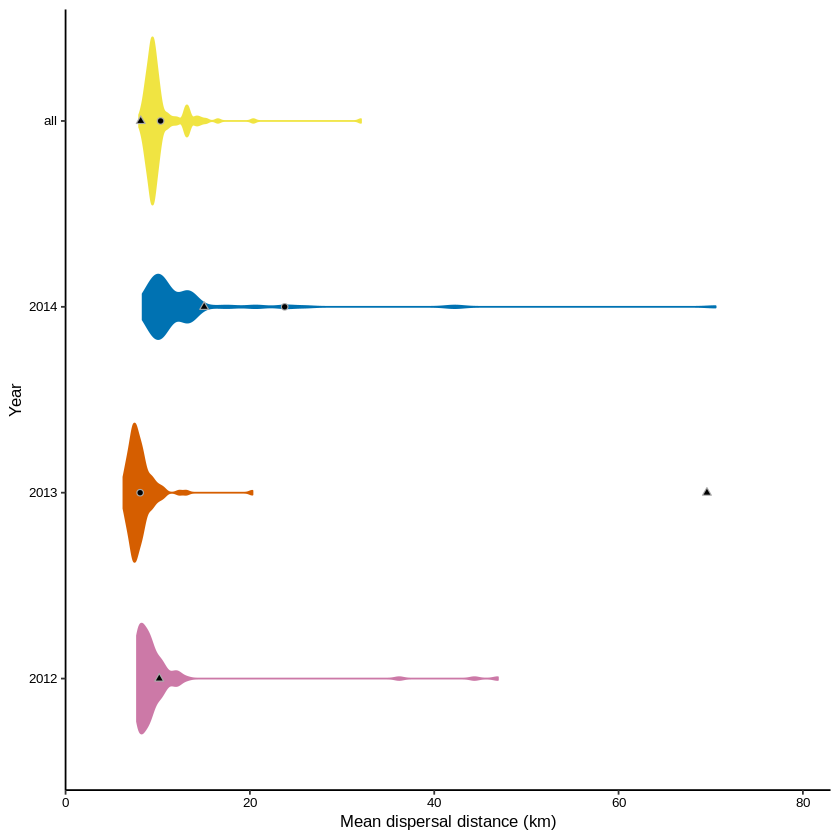

In [111]:
cbbPalette <- c("#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")
cbbPalette_rev <- rev(cbbPalette)

mdd_violin <- ggplot(data=SimCombinedSummary, aes(x=year, y=mdd, color=year, fill=year), alpha=0.5) +
    geom_violin() +
    #geom_point(data=AverageFits2, aes(x=year, y=mdd), fill="snow",color="darkgray", shape=21) + #without borderline fits
    geom_point(data=AverageFits, aes(x=year, y=mdd), fill="black ",color="darkgray", shape=21) + # with all fits
    geom_point(data=kernels %>% filter(Year %in% c("2012", "2013", "2014", "all")), aes(x=Year, y=MeanDispDist), fill="black",color="darkgray", shape=24) + #genetic estimates
    coord_flip() +
    #scale_x_continuous(limits = c(0, 100), expand=c(0,0)) +
    scale_y_continuous(limits = c(0, 83), expand = c(0,0))+
    theme(panel.grid.major = element_blank(),
    plot.margin=unit(c(0.2,0.2,0.2,0.2),"cm"),
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), #,
    axis.line = element_line(colour = "black")) +
    xlab("Year") + 
    ylab("Mean dispersal distance (km)") +
    theme(axis.text.x = element_text(size=8, color="black", family="Helvetica"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.text.y =  element_text(size=8, color="black", family="Helvetica"),
    axis.title.y =  element_text(size=10, color="black", family="Helvetica"), 
    axis.title.x =  element_text(size=10, color="black", family="Helvetica"),    
    legend.position = "none") + 
    scale_colour_manual(values=cbbPalette_rev)+
    scale_fill_manual(values=cbbPalette_rev)
    #scale_y_continuous(breaks = 1:2000, labels = c(1:50,"break",1000:2000))
mdd_violin
ggplot2::ggsave(filename="SimMeanDispDistPlusGenPoints.png",  plot=mdd_violin, width=83, height=70, units="mm", path="~/oceanography/script_output/KernelFits/Plots/")


In [81]:
AverageFits
AverageFits2

year,k,theta,mdd,kurtosis
2012,-1.393954,1.262979,132.061691,1120.152715
2013,-1.242150,0.804757,8.091848,13.967938
2014,-2.205898,2.594447,23.772475,68.917290
all,-1.962497,1.231269,10.310988,8.334333


year,k,theta,mdd,kurtosis
2012,-1.828326,1.250510,10.127328,15.518027
2013,-1.242150,0.804757,8.091848,13.967938
2014,-1.926596,1.243059,26.376964,86.415760
all,-1.919426,1.014670,10.219857,8.635482


In [116]:
SimPlusGenFits <- inner_join(AverageFits2, kernels %>% select(Year, best_k, best_theta, MeanDispDist, MedianDispDist) , by=c(year="Year")) %>%
    rename(SimK="k", SimTheta="theta", SimMDD="mdd", GenK="best_k", GenTheta="best_theta", GenMDD="MeanDispDist", GenMedDispDist="MedianDispDist")

#write.csv(SimPlusGenFits, file="~/oceanography/script_output/KernelFits/SimPlusGenKernelFits.csv", row.names=F)

In [115]:
(SimPlusGenFits)

year,SimK,SimTheta,SimMDD,SimKurtosis,GenK,GenTheta,GenMDD,GenMedDispDist
2012,-1.828326,1.250510,10.127328,15.518027,-2.36,1.03,10.165094,7.13
2013,-1.242150,0.804757,8.091848,13.967938,4.04,0.22,69.586280,12.20
2014,-1.926596,1.243059,26.376964,86.415760,0.49,0.38,15.037515,5.53
all,-1.919426,1.014670,10.219857,8.635482,-2.51,1.49,8.153016,6.44


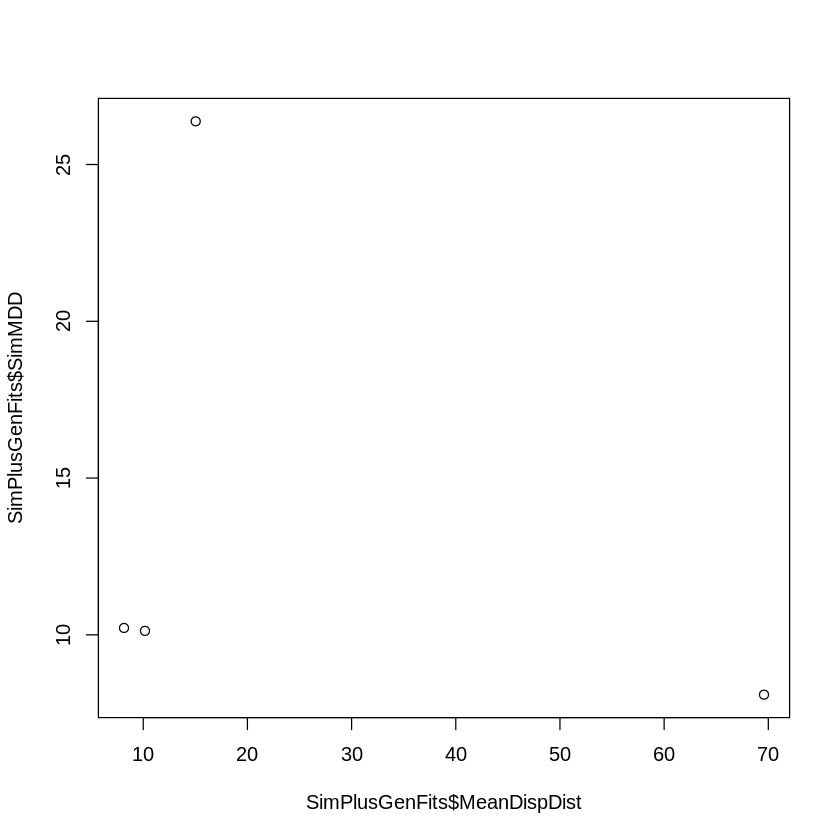

In [95]:
plot(SimPlusGenFits$SimMDD~SimPlusGenFits$MeanDispDist)

In [97]:
#test for correlations
cor.test(SimPlusGenFits$SimMDD, SimPlusGenFits$MeanDispDist,  method = "pearson")
cor.test(SimPlusGenFits$SimTheta, SimPlusGenFits$GenTheta,  method = "pearson")



	Pearson's product-moment correlation

data:  SimPlusGenFits$SimMDD and SimPlusGenFits$MeanDispDist
t = -0.53384, df = 2, p-value = 0.6468
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.9812079  0.9202897
sample estimates:
       cor 
-0.3531582 



	Pearson's product-moment correlation

data:  SimPlusGenFits$SimTheta and SimPlusGenFits$GenTheta
t = 0.32913, df = 2, p-value = 0.7733
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.9389710  0.9752907
sample estimates:
      cor 
0.2266754 


In [17]:
#seasons
SimulatedKernelsNEM <-  read.csv(file="~/oceanography/script_output/KernelFits/100SimulatedKernelsNEM.csv", header=T)
SimulatedKernelsSWM <-  read.csv(file="~/oceanography/script_output/KernelFits/100SimulatedKernelsSWM.csv", header=T)
CombinedSeasons <- bind_rows(SimulatedKernelsNEM, SimulatedKernelsSWM) %>%
    select(-iteration)

In [21]:
#get a distribution of MDD from the combinations of theta and k 

col= "mdd"
MDDSimCombinedSeas <- as.data.frame(matrix(nrow=nrow(CombinedSeasons), ncol=1))
colnames(MDDSimCombinedSeas) <- col


start <- Sys.time()
for(i in 1:nrow(CombinedSeasons)){
    
    k_eval <- as.numeric(CombinedSeasons$k)[i]
    theta_eval <- as.numeric(CombinedSeasons$theta)[i]
    mdd_eval <-  as.data.frame(as.matrix(cubintegrate(integrate_kernel_sum1, lower = 0, upper = Inf, k=k_eval, theta=theta_eval, relTol = 1e-05,  method = "pcubature")$integral))
    MDDSimCombinedSeas[i,] <- mdd_eval
    
    }

MDDSimCombinedSeas <- bind_cols(CombinedSeasons, MDDSimCombinedSeas)
end <- Sys.time()
end-start
#write.csv(MDDSimCombinedSeas, file="~/oceanography/script_output/KernelFits/MDDSimulatedKernelsCombinedSeasons.csv", quote=FALSE, row.names=F )



Time difference of 0.2395151 secs

In [25]:
MDDSimCombinedSeas %>%
    group_by(season) %>%
    summarise_each(funs(mean))

MDDSimCombinedSeas %>%
    group_by(season) %>%
    filter(k==10 |k==-10 | theta==0.15 |theta== 8) %>% #how often are the fits at the boundary? as in, bad
    summarise(NObsBad=n())

season,k,theta,mdd
NEM,-2.005686,1.081461,10.108771
SWM,-2.386560,1.337738,8.701934


`summarise()` ungrouping output (override with `.groups` argument)


season,NObsBad
NEM,1


In [24]:
SeasonalKernels <- read.csv(file="~/parentage/kernel_fitting/1340_loci/final_results/tables/RecruitSizeAsSeasonlity_summary.csv", header=T)
head(SeasonalKernels)

Season,RecruitSizeAtSampling,best_k,best_theta,k_CI95_lower,k_CI95_upper,theta_CI95_lower,theta_CI95_upper,MeanDispersalDistance,MeanDispDist_CI95_lower,MeanDispDist_CI95_upper,MedianDispersalDistance,MedianDispDist_CI95_lower,MedianDispDist_CI95_upper,Dist90Retained
SWM,> 4.5 cm,-2.60,1.58,-2.63,-2.47,1.34,1.59,8.574871,7.132250,10.39623,6.87,4.93,9.28,18.32
NEM,< 3.5 cm,-0.89,0.56,-1.46,-0.74,0.54,0.61,9.446898,6.014163,4272.46841,4.82,3.24,323.37,23.60
